# Kickstarter Projects
https://www.kaggle.com/kemical/kickstarter-projects

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime as dt
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,KFold
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,RandomForestRegressor,AdaBoostRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
import xgboost as xgb
import lightgbm as lgb

Using TensorFlow backend.


## 目次

- <a href = "#前処理">前処理</a>
- <a href ="#回帰手法でusd_pledgedを予測">回帰手法でusd_pledgedを予測</a>
- <a href="#分類手法で学習とテスト">分類手法で学習とテスト</a>

## 前処理

In [3]:
# データの確認
df = pd.read_csv("raw_data/ks-projects-201801.csv")
df['ID'] = df['ID'].astype(str)  # IDは文字型としての統計を見たいので型変換
display(df.head())
display(df.describe(include='all'))
print(df.isnull().sum())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
count,378661,378657,378661,378661,378661,378661,3.786610e+05,378661,3.786610e+05,378661,378661.000000,378661,3.748640e+05,3.786610e+05,3.786610e+05
unique,378661,375764,159,15,14,3164,NaN,378089,NaN,6,NaN,23,NaN,NaN,NaN
top,884249360,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08,NaN,1970-01-01 01:00:00,NaN,failed,NaN,US,NaN,NaN,NaN
freq,1,41,22314,63585,295365,705,NaN,7,NaN,197719,NaN,292627,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,4.908079e+04,NaN,9.682979e+03,NaN,105.617476,NaN,7.036729e+03,9.058924e+03,4.545440e+04
std,NaN,NaN,NaN,NaN,NaN,NaN,1.183391e+06,NaN,9.563601e+04,NaN,907.185035,NaN,7.863975e+04,9.097334e+04,1.152950e+06
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e-02,NaN,0.000000e+00,NaN,0.000000,NaN,0.000000e+00,0.000000e+00,1.000000e-02
25%,NaN,NaN,NaN,NaN,NaN,NaN,2.000000e+03,NaN,3.000000e+01,NaN,2.000000,NaN,1.698000e+01,3.100000e+01,2.000000e+03
50%,NaN,NaN,NaN,NaN,NaN,NaN,5.200000e+03,NaN,6.200000e+02,NaN,12.000000,NaN,3.947200e+02,6.243300e+02,5.500000e+03
75%,NaN,NaN,NaN,NaN,NaN,NaN,1.600000e+04,NaN,4.076000e+03,NaN,56.000000,NaN,3.034090e+03,4.050000e+03,1.550000e+04


ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64


### 使用するデータ  
1.目標はクラウドファンディングの成否を事前に予測することなので、成否が決まった後のデータ及びbackerに関するデータである「pledged, backers, usd pledged, currency, country」は使用しないので落とす。ただしusd_pledged_realは回帰問題の目的変数として利用できるので残しておく。  
2.欠損値はnameの4データのみ。データは378,000件もあるので落としてしまう。  
3.目的変数であるstateには成否以外に4つの状態が含まれているが、今回は取り扱わないので落とす。

In [4]:
df = pd.read_csv("raw_data/ks-projects-201801.csv")
df = df.drop(["ID","currency","pledged","goal","backers","usd pledged","country"],axis=1)
df = df.dropna()
df = df.query("state == 'successful' or state =='failed'")
df.head()

,name,category,main_category,deadline,launched,state,usd_pledged_real,usd_goal_real
0,The Songs of Adelaide & Abullah,Poetry,Publishing,2015-10-09,2015-08-11 12:12:28,failed,0.0,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,2421.0,30000.00
2,Where is Hank?,Narrative Film,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,220.0,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,2012-04-16,2012-03-17 03:24:11,failed,1.0,5000.00
5,Monarch Espresso Bar,Restaurants,Food,2016-04-01,2016-02-26 13:38:27,successful,52375.0,50000.00


### usd_goal_real,usd_goal_realの加工    
ほとんどが1e5USD以下であるが、1e8スケールのデータも存在するので正規化はもちろん、標準化もきつそう  
今回は対数変換したデータを使用する

(array([3.31512e+05, 7.00000e+01, 2.40000e+01, 1.30000e+01, 5.00000e+00,
        2.00000e+00, 1.40000e+01, 1.00000e+00, 1.00000e+00, 4.00000e+00,
        2.00000e+00, 0.00000e+00, 2.10000e+01, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([1.00000000e-02, 8.31806955e+06, 1.66361391e+07, 2.49542086e+07,
        3.32722782e+07, 4.15903477e+07, 4.99084172e+07, 5.82264868e+07,
        6.65445563e+07, 7.48626258e+07, 8.31806954e+07, 9.14987649e+07,
        9.98168344e+07, 1.08134904e+08, 1.16452974e+08, 1.24771043e+08,
        1.33089113e+08, 1.41407182e+08, 1.49725252e+08, 1.58043321e+08,
        1.66361391e+08]),
 <a list of 20 Patch objects>)

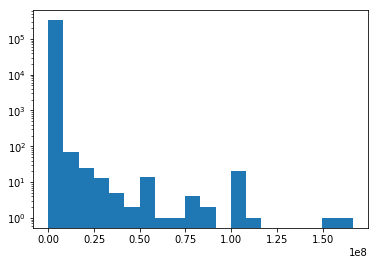

In [188]:
# usd_goal_realのヒストグラム
plt.hist(df["usd_goal_real"], bins=20,log=True)

(array([3.6100e+02, 1.5500e+02, 6.8600e+02, 1.0270e+03, 3.2860e+03,
        6.1280e+03, 2.5199e+04, 4.1482e+04, 8.9717e+04, 7.0249e+04,
        5.3843e+04, 2.5842e+04, 9.0670e+03, 3.0560e+03, 9.0000e+02,
        3.9000e+02, 1.3800e+02, 8.6000e+01, 2.9000e+01, 3.1000e+01]),
 array([9.95033085e-03, 9.55936466e-01, 1.90192260e+00, 2.84790874e+00,
        3.79389487e+00, 4.73988101e+00, 5.68586714e+00, 6.63185328e+00,
        7.57783941e+00, 8.52382555e+00, 9.46981168e+00, 1.04157978e+01,
        1.13617840e+01, 1.23077701e+01, 1.32537562e+01, 1.41997424e+01,
        1.51457285e+01, 1.60917146e+01, 1.70377008e+01, 1.79836869e+01,
        1.89296730e+01]),
 <a list of 20 Patch objects>)

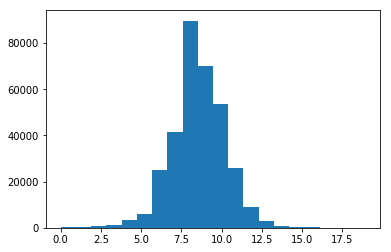

In [189]:
# usd_goal_realの対数ヒストグラム
plt.hist(np.log1p(df["usd_goal_real"]), bins=20)

In [190]:
df["usd_goal_real"] = np.log1p(df["usd_goal_real"])
df["usd_pledged_real"] = np.log1p(df["usd_pledged_real"])
df.head()

,name,category,main_category,deadline,launched,state,usd_pledged_real,usd_goal_real
0,The Songs of Adelaide & Abullah,Poetry,Publishing,2015-10-09,2015-08-11 12:12:28,failed,0.000000,7.336253
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,7.792349,10.308986
2,Where is Hank?,Narrative Film,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,5.398163,10.714440
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,2012-04-16,2012-03-17 03:24:11,failed,0.693147,8.517393
5,Monarch Espresso Bar,Restaurants,Food,2016-04-01,2016-02-26 13:38:27,successful,10.866204,10.819798


### launched,deadlineの加工  
deadline,launchedはstr型なので加工して必要なデータを取り出す。  
- 募集期間(launchedからdeadlineまでの日数)
- launchedに異常値が含まれているので、募集期間はkickstarterで選べる最小の30日とする
- それぞれの日,月のデータ(年度によっても成功率が変化するが今回の目的は将来のプロジェクトの成否予測なので、年データは含めない)

In [191]:
df["period"] = (pd.to_datetime(df["deadline"])-pd.to_datetime(df["launched"])).astype('timedelta64[D]')
df.loc[(df['period'] < 30), 'period'] = 30
df["deadline_month"] = pd.to_datetime(df["deadline"]).dt.month
df["deadline_day"] = pd.to_datetime(df["deadline"]).dt.day
df["launched_month"] = pd.to_datetime(df["launched"]).dt.month
df["launched_day"] = pd.to_datetime(df["launched"]).dt.day
df = df.drop(["launched","deadline"],axis=1)
df.head()

,name,category,main_category,state,usd_pledged_real,usd_goal_real,period,deadline_month,deadline_day,launched_month,launched_day
0,The Songs of Adelaide & Abullah,Poetry,Publishing,failed,0.000000,7.336253,58.0,10,9,8,11
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,failed,7.792349,10.308986,59.0,11,1,9,2
2,Where is Hank?,Narrative Film,Film & Video,failed,5.398163,10.714440,44.0,2,26,1,12
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,failed,0.693147,8.517393,30.0,4,16,3,17
5,Monarch Espresso Bar,Restaurants,Food,successful,10.866204,10.819798,34.0,4,1,2,26


### nameの加工
- 今回は単純に文字数と単語数のみを特徴量に加える

In [192]:
df["letters"] = df["name"].apply(lambda x: len(str(x).replace(' ', '')))
df["words"] = df["name"].apply(lambda x: len(x.split()))
df = df.drop(["name"],axis=1)
df.head()

,category,main_category,state,usd_pledged_real,usd_goal_real,period,deadline_month,deadline_day,launched_month,launched_day,letters,words
0,Poetry,Publishing,failed,0.000000,7.336253,58.0,10,9,8,11,26,6
1,Narrative Film,Film & Video,failed,7.792349,10.308986,59.0,11,1,9,2,38,8
2,Narrative Film,Film & Video,failed,5.398163,10.714440,44.0,2,26,1,12,12,3
3,Music,Music,failed,0.693147,8.517393,30.0,4,16,3,17,43,7
5,Restaurants,Food,successful,10.866204,10.819798,34.0,4,1,2,26,18,3


### 相関係数の確認  
- やはりnameの文字列と単語数は相関が高いので、今回は文字列を落とす

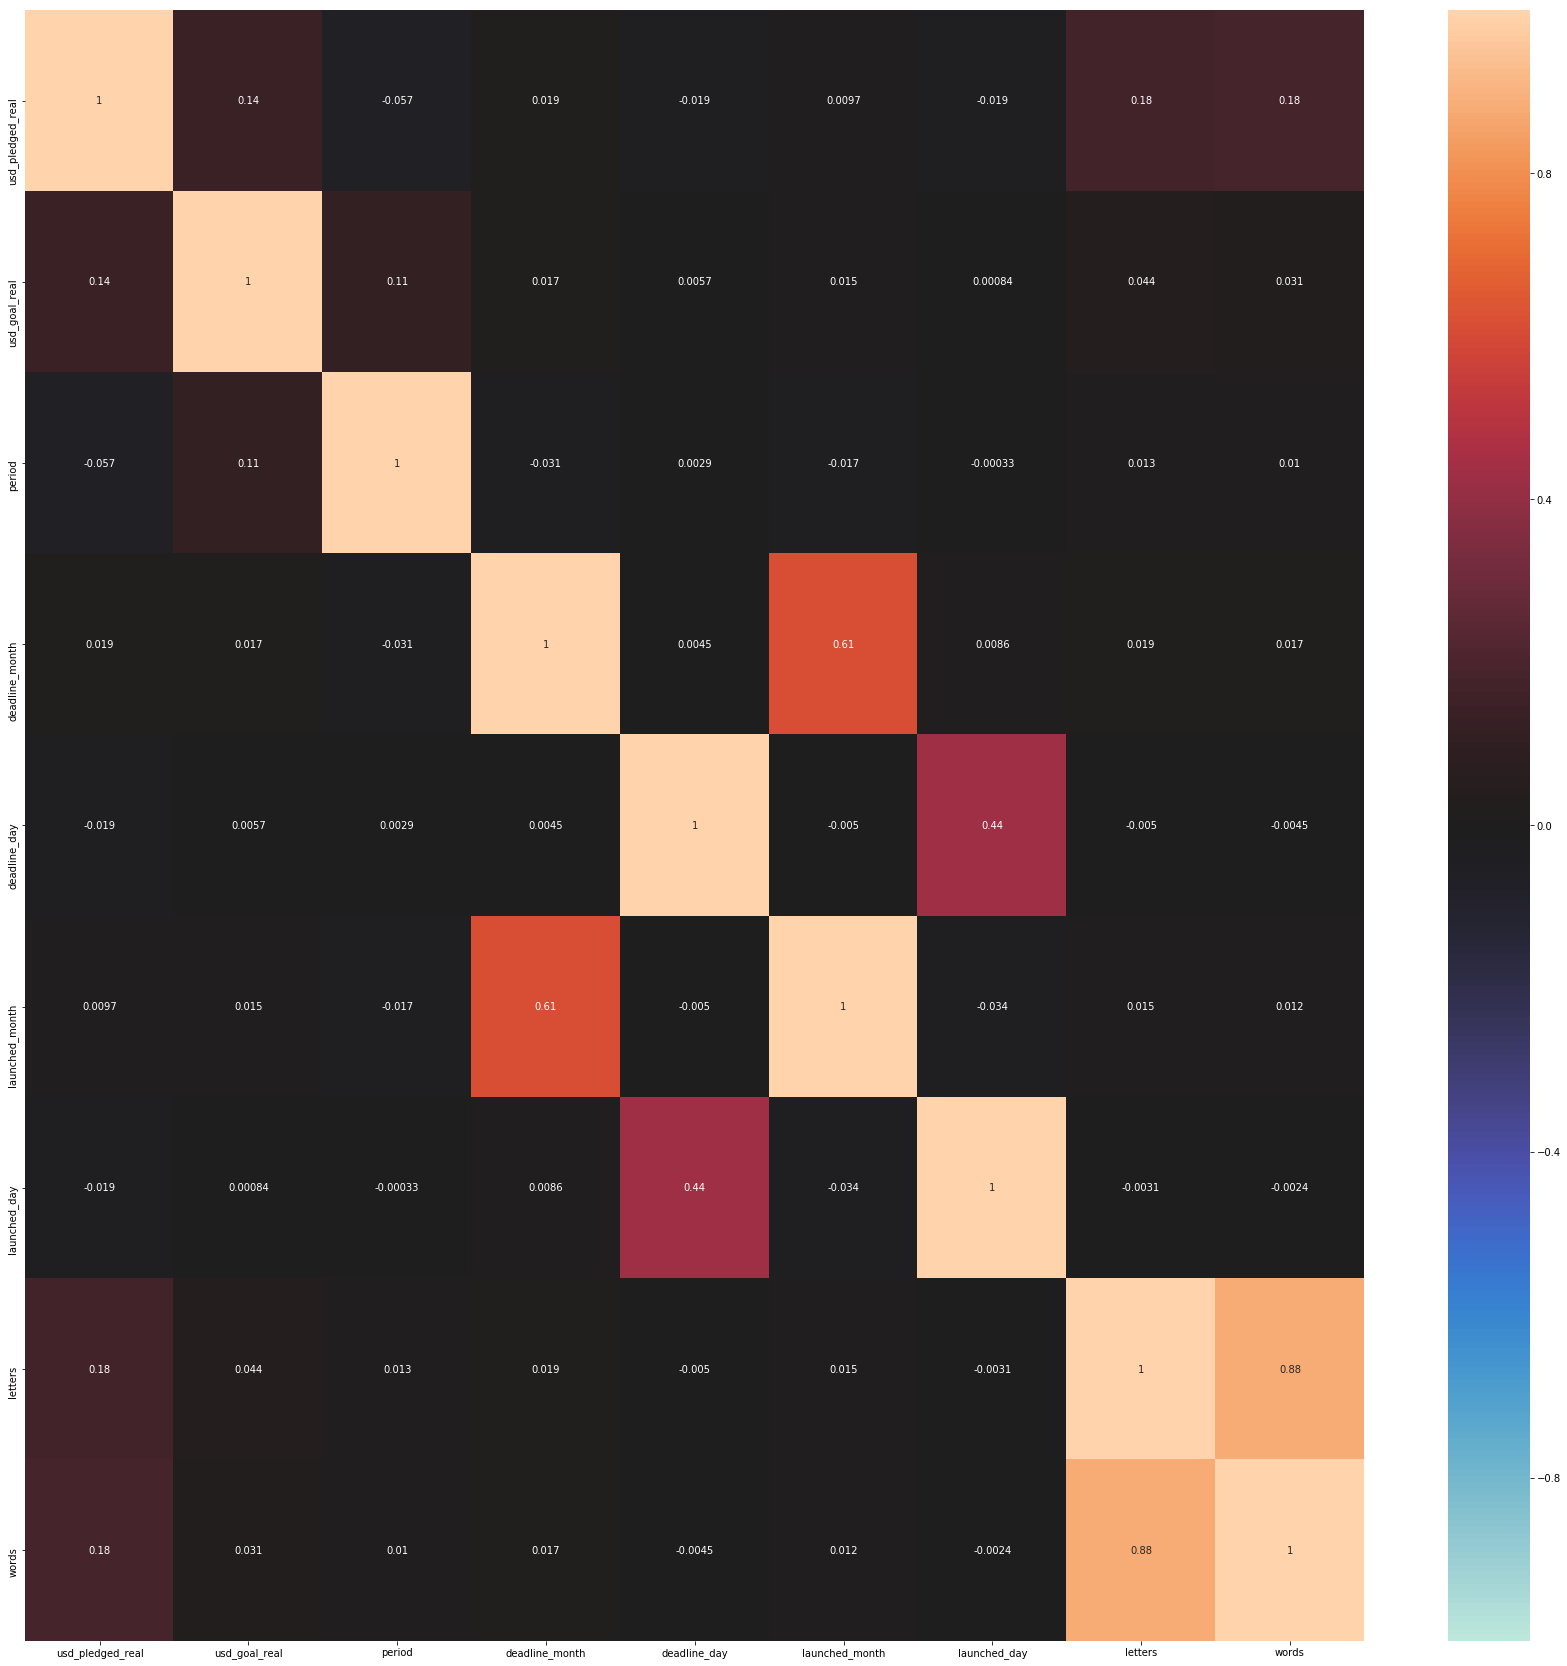

In [193]:
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
sns.heatmap(df.corr(), vmax=1, vmin=-1, center=0, annot=True, ax=ax)

In [194]:
df = df.drop(["words"],axis=1)

### カテゴリ変数の加工  
- 成功=1,失敗=0とし、category,main_categoryもone-hotエンコーディングする

In [12]:
# main_categoryに含まれるcategory数
df.groupby("main_category")["category"].nunique()

main_category
Art             13
Comics           6
Crafts          15
Dance            5
Design           7
Fashion          9
Film & Video    20
Food            13
Games            8
Journalism       6
Music           19
Photography      7
Publishing      18
Technology      16
Theater          8
Name: category, dtype: int64

In [14]:
# stateを0/1に置き換え
df["state"] = df["state"].replace("successful",1).replace("failed",0)
# main_category毎の成功確率
df_tmp = df[["main_category", "state"]].groupby(['main_category'], as_index=False).mean().sort_values(by='state', ascending=False)
df_tmp["count"] = df[["main_category", "state"]].groupby(['main_category'], as_index=False).count()["state"]
df_tmp

,main_category,state,count
3,Dance,0.654352,3573
14,Theater,0.637961,10242
1,Comics,0.591415,9878
10,Music,0.526606,45949
0,Art,0.448908,25640
8,Games,0.438920,28520
6,Film & Video,0.417914,56526
4,Design,0.415944,25364
12,Publishing,0.347017,35445
11,Photography,0.341108,9689


In [195]:
# one-hot encoding
for i in df["main_category"].unique():
    df[i] = 0
    df.loc[df['main_category'] == i, i] = 1

for i in df["category"].unique():
    df[i] = 0
    df.loc[df['category'] == i, i] = 1
df = df.drop(["category","main_category"],axis=1)
df.head()

,state,usd_pledged_real,usd_goal_real,period,deadline_month,deadline_day,launched_month,launched_day,letters,Publishing,...,Romance,Civic Design,Kids,Literary Journals,Couture,Taxidermy,Quilts,Chiptune,Residencies,Literary Spaces
0,0,0.000000,7.336253,58.0,10,9,8,11,26,0,...,0,0,0,0,0,0,0,0,0,0
1,0,7.792349,10.308986,59.0,11,1,9,2,38,0,...,0,0,0,0,0,0,0,0,0,0
2,0,5.398163,10.714440,44.0,2,26,1,12,12,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.693147,8.517393,30.0,4,16,3,17,43,0,...,0,0,0,0,0,0,0,0,0,0
5,1,10.866204,10.819798,34.0,4,1,2,26,18,0,...,0,0,0,0,0,0,0,0,0,0


In [196]:
# 一日あたりの目標金額も追加
df["goal/period"] = df["usd_goal_real"] /df["period"]

In [197]:
# 前処理の結果をcsvに保存する
df.to_csv("ks_project_pre.csv")

## 回帰手法でusd_pledgedを予測  
usd_pledged_realは説明変数として使えないが有用な情報を持つので、回帰手法で予測をした値を説明変数として利用する

In [2]:
df = pd.read_csv("ks_project_pre.csv")
df = df.drop("Unnamed: 0",axis=1)

In [3]:
test_size = 0.2
X = df.drop(["state","usd_pledged_real"],axis =1).values
pledged = df["usd_pledged_real"].values
state = df["state"].values
X_train, X_test, pledged_train, pledged_test,state_train,state_test =  train_test_split(X,pledged,state,test_size=test_size, random_state=1234)

### 線形回帰

In [4]:
%%time
params = {'alpha':[1,1e-1, 1e-4]}
model = Ridge(params)
clf = GridSearchCV(model, params, cv=5)
clf.fit(X_train,pledged_train)
print(clf.best_params_, clf.best_score_)

{'alpha': 1} 0.17156540466028167
CPU times: user 21.2 s, sys: 6.76 s, total: 27.9 s
Wall time: 24.1 s


In [5]:
# MAEを計算
linear_est = clf.predict(X_test)
mae = mean_absolute_error(pledged_test, linear_est) 
print("MAE = %s"%round(mae,3) )

MAE = 2.395


### Rondom Forest回帰

In [6]:
%%time
clf2 = RandomForestRegressor(n_estimators=10, max_depth=20, criterion="mse",
                                                 min_samples_leaf=10, min_samples_split=10, random_state=1234)
clf2 = clf2.fit(X_train, pledged_train)

CPU times: user 2min 53s, sys: 2.39 s, total: 2min 55s
Wall time: 3min 10s


In [7]:
# MAEを計算
rf_est = clf2.predict(X_test)
mae = mean_absolute_error(pledged_test, rf_est) 
print("MAE = %s"%round(mae,3) )

MAE = 2.388


#### 重要度の表示  
追加した数値データが概ね高い重要度になっている。main_categoryは最高で[Theater:0.007996]止まり。categoryの方が重要なのだろう。

In [8]:
pd.DataFrame(clf2.feature_importances_, index = df.drop(["state","usd_pledged_real"],axis =1).columns).sort_values(0,ascending=False)[:20]

,0
usd_goal_real,0.175145
letters,0.160516
goal/period,0.091082
Tabletop Games,0.084751
period,0.082821
Product Design,0.042617
deadline_day,0.041395
launched_day,0.041059
Apps,0.032948
Web,0.029653


### Neural Network回帰

In [9]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))

adam = Adam(lr=0.0001)

model.compile(loss='mse',
              optimizer=adam,
              metrics=['mae'])

In [12]:
# 計算の実行
fit = model.fit(X_train, pledged_train,
          epochs=10,
          batch_size=32,validation_data=(X_test, pledged_test))

Train on 265337 samples, validate on 66335 samples
Epoch 1/10
265337/265337 [==============================] - 17s 63us/step - loss: 8.6779 - mean_absolute_error: 2.3846 - val_loss: 8.5581 - val_mean_absolute_error: 2.4307
Epoch 2/10
265337/265337 [==============================] - 17s 62us/step - loss: 8.6511 - mean_absolute_error: 2.3804 - val_loss: 8.4692 - val_mean_absolute_error: 2.3967
Epoch 3/10
265337/265337 [==============================] - 17s 65us/step - loss: 8.6330 - mean_absolute_error: 2.3777 - val_loss: 8.4243 - val_mean_absolute_error: 2.3807
Epoch 4/10
265337/265337 [==============================] - 18s 67us/step - loss: 8.6189 - mean_absolute_error: 2.3744 - val_loss: 8.4841 - val_mean_absolute_error: 2.4077
Epoch 5/10
265337/265337 [==============================] - 17s 64us/step - loss: 8.6017 - mean_absolute_error: 2.3719 - val_loss: 8.4205 - val_mean_absolute_error: 2.3906
Epoch 6/10
265337/265337 [==============================] - 17s 64us/step - loss: 8.5776 

In [13]:
# MAEを計算
nn_est = model.predict(X_test)
mae = mean_absolute_error(pledged_test, nn_est) 
print("MAE = %s"%round(mae,3) )

MAE = 2.398


### ensamble  
それぞれの加重平均をとってもっともMAEが良いものを採用する。

In [17]:
ens_est = (0.5 * linear_est + 0.5 * rf_est)
mae = mean_absolute_error(pledged_test, ens_est) 
print("MAE = %s"%round(mae,4) )

MAE = 2.3625


In [18]:
linear_train = clf.predict(X_train)
rf_train = clf2.predict(X_train)
train_est = (0.4 * linear_train + 0.6 * rf_train)
mae = mean_absolute_error(pledged_train, train_est) 
print("MAE = %s"%round(mae,4) )

MAE = 2.303


In [20]:
np.savetxt("train_pledged.csv", train_est, delimiter=",")
np.savetxt("test_pledged.csv", ens_est, delimiter=",")

### 特徴量に追加  

In [23]:
# pledged - goalも特徴量として追加
dif_train = train_est - X_train[:,0]
dif_test = ens_est - X_test[:,0]

In [24]:
# 予測したpledgedをデータセットに加える
X_train2 = X_train
X_train2 = np.insert(X_train2,0,train_est,axis=1)
X_train2 = np.insert(X_train2,0,dif_train,axis=1)
X_test2 = X_test
X_test2 = np.insert(X_test2,0,ens_est,axis=1)
X_test2 = np.insert(X_test2,0,dif_test,axis=1)

In [25]:
# コラム名も用意しておく
X_columns = df.drop(["state","usd_pledged_real"],axis =1).columns
X_columns = np.insert(X_columns,0,"est_pledged")
X_columns = np.insert(X_columns,0,"pledged-goal")

## 分類手法で学習とテスト

### LinerSVC分類

In [26]:
%%time
parameters = {'C':[1e-10,1e-5,1e-1,1],'penalty':['l1','l2'],'dual':[False]} 
model= LinearSVC()
svc = GridSearchCV(model, parameters, cv=5)
svc.fit(X_train2, state_train)
print(svc.best_params_, svc.best_score_)

{'C': 0.1, 'dual': False, 'penalty': 'l2'} 0.6966499206669254
CPU times: user 3min 50s, sys: 12.3 s, total: 4min 2s
Wall time: 4min 13s


In [27]:
svc = LinearSVC(**svc.best_params_)
svc.fit(X_train2, state_train)
print("識別精度=",svc.score(X_test2, state_test))

識別精度= 0.6755709655536293


In [37]:
svc_pred = svc.predict(X_test2)

### 木モデル分類

In [28]:
%%time
# Randomforest
rfc = RandomForestClassifier(n_estimators=15, max_depth=15, criterion="gini",
                                                 min_samples_leaf=10, min_samples_split=10, random_state=1234)
rfc.fit(X_train2, state_train)
print("train_score=", rfc.score(X_train2, state_train))
print("test_score=", rfc.score(X_test2, state_test))

train_score= 0.699080791597101
test_score= 0.6718172910228386
CPU times: user 23.5 s, sys: 490 ms, total: 24 s
Wall time: 25 s


In [29]:
pd.DataFrame(rfc.feature_importances_, index = X_columns).sort_values(0,ascending=False)[:20]

,0
pledged-goal,0.407513
est_pledged,0.143842
usd_goal_real,0.141277
goal/period,0.067780
period,0.036965
letters,0.022283
Tabletop Games,0.018752
Web,0.014179
Theater,0.013079
Apps,0.013039


In [30]:
%%time
# Xgboost
xgc = xgb.XGBClassifier(n_estimators=15, max_depth=10, criterion="gini")
xgc.fit(X_train2, state_train)
print("train_score=", xgc.score(X_train2, state_train))
print("test_score=", xgc.score(X_test2, state_test))

train_score= 0.7093997444758929
test_score= 0.670837416145323
CPU times: user 58.2 s, sys: 2 s, total: 1min
Wall time: 1min 5s


In [31]:
# lightgbm
lgb_train = lgb.Dataset(X_train2,state_train)
lgb_eval = lgb.Dataset(X_test2,state_test)
params = {
'objective': 'binary',
'metric': {'binary_error'},
}

In [32]:
%%time
gbm = lgb.train(params,lgb_train,num_boost_round=1000,valid_sets=lgb_eval)

[1]	valid_0's binary_error: 0.403799
[2]	valid_0's binary_error: 0.403799
[3]	valid_0's binary_error: 0.377041
[4]	valid_0's binary_error: 0.358107
[5]	valid_0's binary_error: 0.350644
[6]	valid_0's binary_error: 0.34567
[7]	valid_0's binary_error: 0.341464
[8]	valid_0's binary_error: 0.337921
[9]	valid_0's binary_error: 0.335931
[10]	valid_0's binary_error: 0.334228
[11]	valid_0's binary_error: 0.333881
[12]	valid_0's binary_error: 0.333082
[13]	valid_0's binary_error: 0.332087
[14]	valid_0's binary_error: 0.332449
[15]	valid_0's binary_error: 0.331936
[16]	valid_0's binary_error: 0.331499
[17]	valid_0's binary_error: 0.331424
[18]	valid_0's binary_error: 0.330821
[19]	valid_0's binary_error: 0.330052
[20]	valid_0's binary_error: 0.32957
[21]	valid_0's binary_error: 0.328801
[22]	valid_0's binary_error: 0.328424
[23]	valid_0's binary_error: 0.328318
[24]	valid_0's binary_error: 0.327474
[25]	valid_0's binary_error: 0.327685
[26]	valid_0's binary_error: 0.327429
[27]	valid_0's binary_e

[221]	valid_0's binary_error: 0.321942
[222]	valid_0's binary_error: 0.322017
[223]	valid_0's binary_error: 0.321957
[224]	valid_0's binary_error: 0.321972
[225]	valid_0's binary_error: 0.321942
[226]	valid_0's binary_error: 0.321912
[227]	valid_0's binary_error: 0.321927
[228]	valid_0's binary_error: 0.321972
[229]	valid_0's binary_error: 0.321896
[230]	valid_0's binary_error: 0.321912
[231]	valid_0's binary_error: 0.321912
[232]	valid_0's binary_error: 0.3217
[233]	valid_0's binary_error: 0.321776
[234]	valid_0's binary_error: 0.321776
[235]	valid_0's binary_error: 0.321836
[236]	valid_0's binary_error: 0.321821
[237]	valid_0's binary_error: 0.321776
[238]	valid_0's binary_error: 0.321806
[239]	valid_0's binary_error: 0.321776
[240]	valid_0's binary_error: 0.321836
[241]	valid_0's binary_error: 0.321942
[242]	valid_0's binary_error: 0.321896
[243]	valid_0's binary_error: 0.321942
[244]	valid_0's binary_error: 0.321942
[245]	valid_0's binary_error: 0.322002
[246]	valid_0's binary_erro

[435]	valid_0's binary_error: 0.323163
[436]	valid_0's binary_error: 0.323163
[437]	valid_0's binary_error: 0.323148
[438]	valid_0's binary_error: 0.323133
[439]	valid_0's binary_error: 0.323133
[440]	valid_0's binary_error: 0.323133
[441]	valid_0's binary_error: 0.323118
[442]	valid_0's binary_error: 0.323178
[443]	valid_0's binary_error: 0.323163
[444]	valid_0's binary_error: 0.323178
[445]	valid_0's binary_error: 0.323163
[446]	valid_0's binary_error: 0.323208
[447]	valid_0's binary_error: 0.323072
[448]	valid_0's binary_error: 0.323148
[449]	valid_0's binary_error: 0.323102
[450]	valid_0's binary_error: 0.322997
[451]	valid_0's binary_error: 0.323072
[452]	valid_0's binary_error: 0.322982
[453]	valid_0's binary_error: 0.323027
[454]	valid_0's binary_error: 0.323027
[455]	valid_0's binary_error: 0.323027
[456]	valid_0's binary_error: 0.322997
[457]	valid_0's binary_error: 0.322831
[458]	valid_0's binary_error: 0.322816
[459]	valid_0's binary_error: 0.322801
[460]	valid_0's binary_er

[654]	valid_0's binary_error: 0.322771
[655]	valid_0's binary_error: 0.322801
[656]	valid_0's binary_error: 0.32271
[657]	valid_0's binary_error: 0.322665
[658]	valid_0's binary_error: 0.322695
[659]	valid_0's binary_error: 0.322695
[660]	valid_0's binary_error: 0.32268
[661]	valid_0's binary_error: 0.32265
[662]	valid_0's binary_error: 0.32268
[663]	valid_0's binary_error: 0.322665
[664]	valid_0's binary_error: 0.322695
[665]	valid_0's binary_error: 0.32271
[666]	valid_0's binary_error: 0.322726
[667]	valid_0's binary_error: 0.32268
[668]	valid_0's binary_error: 0.32268
[669]	valid_0's binary_error: 0.322741
[670]	valid_0's binary_error: 0.322771
[671]	valid_0's binary_error: 0.322816
[672]	valid_0's binary_error: 0.322816
[673]	valid_0's binary_error: 0.322816
[674]	valid_0's binary_error: 0.322786
[675]	valid_0's binary_error: 0.322801
[676]	valid_0's binary_error: 0.322831
[677]	valid_0's binary_error: 0.322816
[678]	valid_0's binary_error: 0.322846
[679]	valid_0's binary_error: 0.

[865]	valid_0's binary_error: 0.323238
[866]	valid_0's binary_error: 0.323283
[867]	valid_0's binary_error: 0.323298
[868]	valid_0's binary_error: 0.323283
[869]	valid_0's binary_error: 0.323329
[870]	valid_0's binary_error: 0.323253
[871]	valid_0's binary_error: 0.323193
[872]	valid_0's binary_error: 0.323268
[873]	valid_0's binary_error: 0.323283
[874]	valid_0's binary_error: 0.323253
[875]	valid_0's binary_error: 0.323283
[876]	valid_0's binary_error: 0.323268
[877]	valid_0's binary_error: 0.323283
[878]	valid_0's binary_error: 0.323163
[879]	valid_0's binary_error: 0.323163
[880]	valid_0's binary_error: 0.323178
[881]	valid_0's binary_error: 0.323148
[882]	valid_0's binary_error: 0.323148
[883]	valid_0's binary_error: 0.323118
[884]	valid_0's binary_error: 0.323102
[885]	valid_0's binary_error: 0.323148
[886]	valid_0's binary_error: 0.323133
[887]	valid_0's binary_error: 0.323133
[888]	valid_0's binary_error: 0.323163
[889]	valid_0's binary_error: 0.323208
[890]	valid_0's binary_er

In [33]:
lgb_pred = gbm.predict(X_test2, num_iteration=gbm.best_iteration)
lgb_pred = np.where(lgb_pred > 0.5, 1, 0)
print('識別精度=',accuracy_score(state_test, lgb_pred))

識別精度= 0.676867415391573


### Neural Network分類

In [173]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train2.shape[1]))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

adam = Adam(lr=0.0001)

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [35]:
# 計算の実行
nnc = model.fit(X_train2, state_train,
          epochs=10,
          batch_size=32,validation_data=(X_test2, state_test))

Train on 265337 samples, validate on 66335 samples
Epoch 1/10
265337/265337 [==============================] - 22s 83us/step - loss: 0.6496 - acc: 0.6379 - val_loss: 0.5955 - val_acc: 0.6683
Epoch 2/10
265337/265337 [==============================] - 22s 81us/step - loss: 0.5843 - acc: 0.6784 - val_loss: 0.5926 - val_acc: 0.6721
Epoch 3/10
265337/265337 [==============================] - 21s 79us/step - loss: 0.5771 - acc: 0.6853 - val_loss: 0.5906 - val_acc: 0.6745
Epoch 4/10
265337/265337 [==============================] - 21s 77us/step - loss: 0.5729 - acc: 0.6899 - val_loss: 0.5924 - val_acc: 0.6743
Epoch 5/10
265337/265337 [==============================] - 21s 81us/step - loss: 0.5709 - acc: 0.6918 - val_loss: 0.5900 - val_acc: 0.6754
Epoch 6/10
265337/265337 [==============================] - 20s 77us/step - loss: 0.5690 - acc: 0.6924 - val_loss: 0.5894 - val_acc: 0.6753
Epoch 7/10
265337/265337 [==============================] - 20s 74us/step - loss: 0.5673 - acc: 0.6943 - val_

In [44]:
nn_pred = model.predict(X_test2)
nn_pred = np.where(nn_pred > 0.5, 1, 0)
print('識別精度=',accuracy_score(state_test, nn_pred))

識別精度= 0.6762794904650636


### 学習結果の比較とensemble 
svc,lgb,nnと回帰で得たpledgedとgoalを直接比較して予測したものを比較

In [17]:
df = pd.read_csv("raw_data/ks-projects-201801.csv")
category = df["main_category"].unique()

In [130]:
df2 = pd.DataFrame(X_test2, columns = X_columns)
df2["state"] = state_test
df2["nn_pred"] = nn_pred 
df2["lgb_pred"] = lgb_pred
df2["svc_pred"] = svc_pred
# 回帰で得たpledgedとgoalを比較してstateを予測
df2["reg_pred"] = df2["est_pledged"] >= df2["usd_goal_real"]

In [15]:
# 予測結果をcsvに保存する
#df2.to_csv("ks_project_est.csv")
df2 = pd.read_csv("ks_project_est.csv")

In [18]:
states = ["state","nn_pred","lgb_pred","svc_pred","reg_pred"]
category = category.tolist()
params = states + category
df2 = df2[params]
df2.head()

,state,nn_pred,lgb_pred,svc_pred,reg_pred,Publishing,Film & Video,Music,Food,Design,Crafts,Games,Comics,Fashion,Theater,Art,Photography,Technology,Dance,Journalism
0,1,0,0,0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,1,1,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# 各手法での成否を追加
df2["reg_jdg"] = df2["state"] == df2["reg_pred"]
df2["nn_jdg"] = df2["state"] == df2["nn_pred"]
df2["lgb_jdg"] = df2["state"] == df2["lgb_pred"]
df2["svc_jdg"] = df2["state"] == df2["svc_pred"]

In [20]:
# 空白があると後の処理がうまくいかないのでリネーム
df2 = df2.rename(columns={'Film & Video': 'Film'})
category[1] = "Film"

In [142]:
# main_category毎の正答数を出す
judges = ["nn_jdg","lgb_jdg","svc_jdg","reg_jdg"]
for cat in category:
    print(cat)
    num = len(df2.query("{}==1".format(cat)))
    print("データ数=",num)
    print(df2.query("{}==1".format(cat))[judges].sum())
    print("nnの正答率=",df2.query("{}==1".format(cat)).sum()["nn_jdg"]/num)
    print("---------------------------------------")

Publishing
データ数= 981
nn_jdg     643
lgb_jdg    652
svc_jdg    640
reg_jdg    640
dtype: int64
nnの正答率= 0.6554536187563711
---------------------------------------
Film
データ数= 1674
nn_jdg     1110
lgb_jdg    1107
svc_jdg    1111
reg_jdg    1092
dtype: int64
nnの正答率= 0.6630824372759857
---------------------------------------
Music
データ数= 2497
nn_jdg     1483
lgb_jdg    1515
svc_jdg    1501
reg_jdg    1237
dtype: int64
nnの正答率= 0.5939126952342811
---------------------------------------
Food
データ数= 2091
nn_jdg     1404
lgb_jdg    1413
svc_jdg    1418
reg_jdg    1419
dtype: int64
nnの正答率= 0.6714490674318508
---------------------------------------
Design
データ数= 694
nn_jdg     451
lgb_jdg    445
svc_jdg    441
reg_jdg    434
dtype: int64
nnの正答率= 0.6498559077809798
---------------------------------------
Crafts
データ数= 780
nn_jdg     576
lgb_jdg    572
svc_jdg    573
reg_jdg    572
dtype: int64
nnの正答率= 0.7384615384615385
---------------------------------------
Games
データ数= 547
nn_jdg     383
lgb_jdg    39

In [27]:
# nnについてcategory毎の混合行列
for cat in category:
    dft = df2.query("{}==1".format(cat))
    print(cat)
    conf_mat = pd.DataFrame(confusion_matrix(dft["state"], dft["nn_pred"],labels=[1,0]), 
                        index=['正解 = successful', '正解 = failed'], 
                        columns=['予測 = successful', '予測 = failed'])
    display(conf_mat)
    precision, recall, f1_score, _ = precision_recall_fscore_support(dft["state"], dft["nn_pred"],labels=[1,0])
    print('識別精度={:.3f}%'.format(100*accuracy_score(dft["state"], dft["nn_pred"])))
    print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
    print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
    print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
    print("------------------------------------------------------------")

Publishing


,予測 = successful,予測 = failed
正解 = successful,54,288
正解 = failed,41,598


識別精度=66.463%
適合率（Precision） = 56.842%
再現率（Recall） = 15.789%
F1値（F1-score） = 24.714%
------------------------------------------------------------
Film


,予測 = successful,予測 = failed
正解 = successful,178,404
正解 = failed,163,929


識別精度=66.129%
適合率（Precision） = 52.199%
再現率（Recall） = 30.584%
F1値（F1-score） = 38.570%
------------------------------------------------------------
Music


,予測 = successful,予測 = failed
正解 = successful,932,336
正解 = failed,646,583


識別精度=60.673%
適合率（Precision） = 59.062%
再現率（Recall） = 73.502%
F1値（F1-score） = 65.495%
------------------------------------------------------------
Food


,予測 = successful,予測 = failed
正解 = successful,97,580
正解 = failed,98,1316


識別精度=67.575%
適合率（Precision） = 49.744%
再現率（Recall） = 14.328%
F1値（F1-score） = 22.248%
------------------------------------------------------------
Design


,予測 = successful,予測 = failed
正解 = successful,119,156
正解 = failed,93,326


識別精度=64.121%
適合率（Precision） = 56.132%
再現率（Recall） = 43.273%
F1値（F1-score） = 48.871%
------------------------------------------------------------
Crafts


,予測 = successful,予測 = failed
正解 = successful,42,170
正解 = failed,38,530


識別精度=73.333%
適合率（Precision） = 52.500%
再現率（Recall） = 19.811%
F1値（F1-score） = 28.767%
------------------------------------------------------------
Games


,予測 = successful,予測 = failed
正解 = successful,50,126
正解 = failed,22,349


識別精度=72.943%
適合率（Precision） = 69.444%
再現率（Recall） = 28.409%
F1値（F1-score） = 40.323%
------------------------------------------------------------
Comics


,予測 = successful,予測 = failed
正解 = successful,345,132
正解 = failed,194,216


識別精度=63.247%
適合率（Precision） = 64.007%
再現率（Recall） = 72.327%
F1値（F1-score） = 67.913%
------------------------------------------------------------
Fashion


,予測 = successful,予測 = failed
正解 = successful,27,432
正解 = failed,33,1032


識別精度=69.488%
適合率（Precision） = 45.000%
再現率（Recall） = 5.882%
F1値（F1-score） = 10.405%
------------------------------------------------------------
Theater


,予測 = successful,予測 = failed
正解 = successful,819,73
正解 = failed,315,148


識別精度=71.365%
適合率（Precision） = 72.222%
再現率（Recall） = 91.816%
F1値（F1-score） = 80.849%
------------------------------------------------------------
Art


,予測 = successful,予測 = failed
正解 = successful,349,344
正解 = failed,252,539


識別精度=59.838%
適合率（Precision） = 58.070%
再現率（Recall） = 50.361%
F1値（F1-score） = 53.941%
------------------------------------------------------------
Photography


,予測 = successful,予測 = failed
正解 = successful,75,301
正解 = failed,54,612


識別精度=65.931%
適合率（Precision） = 58.140%
再現率（Recall） = 19.947%
F1値（F1-score） = 29.703%
------------------------------------------------------------
Technology


,予測 = successful,予測 = failed
正解 = successful,36,229
正解 = failed,26,841


識別精度=77.473%
適合率（Precision） = 58.065%
再現率（Recall） = 13.585%
F1値（F1-score） = 22.018%
------------------------------------------------------------
Dance


,予測 = successful,予測 = failed
正解 = successful,310,9
正解 = failed,108,26


識別精度=74.172%
適合率（Precision） = 74.163%
再現率（Recall） = 97.179%
F1値（F1-score） = 84.125%
------------------------------------------------------------
Journalism


,予測 = successful,予測 = failed
正解 = successful,8,89
正解 = failed,6,208


識別精度=69.453%
適合率（Precision） = 57.143%
再現率（Recall） = 8.247%
F1値（F1-score） = 14.414%
------------------------------------------------------------


分類手法はどれも同じような傾向しかないので、アンサンブルをしても良い結果にはならなそう。残念ながら回帰から得た結果も分類を上回るケースがなかった。

### 重要度の低い特徴量を落として学習  
ランダムフォレストで上位30位の特徴量だけで学習を試す

In [160]:
feature30 = pd.DataFrame(rfc.feature_importances_, index = X_columns).sort_values(0,ascending=False)[:30].index

In [167]:
X_train3 = pd.DataFrame(X_train2, columns = X_columns)
X_train3 = X_train3[feature30]
X_test3 = pd.DataFrame(X_test2, columns = X_columns)
X_test3 = X_test3[feature30]
X_train3.head()

,pledged-goal,est_pledged,usd_goal_real,goal/period,period,letters,Tabletop Games,Web,Theater,Apps,...,Hip-Hop,Product Design,Apparel,Dance,Rock,Fashion,Software,Crafts,Technology,Jazz
0,-1.511262,9.085398,10.596660,0.271709,39.0,51.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.344461,4.564294,6.908755,0.230292,30.0,16.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.498729,4.183217,4.681946,0.156065,30.0,29.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-4.432132,4.672879,9.105011,0.303500,30.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.975067,7.031634,8.006701,0.266890,30.0,22.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [169]:
%%time
# Randomforest
rfc = RandomForestClassifier(n_estimators=15, max_depth=15, criterion="gini",
                                                 min_samples_leaf=10, min_samples_split=10, random_state=1234)
rfc.fit(X_train3, state_train)
print("train_score=", rfc.score(X_train3, state_train))
print("test_score=", rfc.score(X_test3, state_test))

train_score= 0.7088608071999005
test_score= 0.6715007160624105
CPU times: user 12.2 s, sys: 306 ms, total: 12.5 s
Wall time: 12.9 s


In [175]:
# nnも試す
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train3.shape[1]))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

adam = Adam(lr=0.0001)

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [177]:
# 計算の実行
nnc = model.fit(X_train3, state_train,
          epochs=10,
          batch_size=32,validation_data=(X_test3, state_test))

Train on 265337 samples, validate on 66335 samples
Epoch 1/10
265337/265337 [==============================] - 21s 79us/step - loss: 0.5694 - acc: 0.6921 - val_loss: 0.5935 - val_acc: 0.6723
Epoch 2/10
265337/265337 [==============================] - 19s 71us/step - loss: 0.5688 - acc: 0.6917 - val_loss: 0.5922 - val_acc: 0.6734
Epoch 3/10
265337/265337 [==============================] - 20s 75us/step - loss: 0.5685 - acc: 0.6926 - val_loss: 0.5928 - val_acc: 0.6725
Epoch 4/10
265337/265337 [==============================] - 20s 75us/step - loss: 0.5682 - acc: 0.6931 - val_loss: 0.5918 - val_acc: 0.6734
Epoch 5/10
265337/265337 [==============================] - 19s 70us/step - loss: 0.5674 - acc: 0.6927 - val_loss: 0.5921 - val_acc: 0.6730
Epoch 6/10
265337/265337 [==============================] - 21s 79us/step - loss: 0.5671 - acc: 0.6935 - val_loss: 0.5923 - val_acc: 0.6724
Epoch 7/10
265337/265337 [==============================] - 20s 75us/step - loss: 0.5670 - acc: 0.6932 - val_

改善せず